In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain
import tqdm
import torch
from torch import nn

from model.tgn import TGN
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import EarlyStopMonitor, RandEdgeSampler, get_neighbor_finder
from evaluation.evaluation import eval_edge_prediction, eval_embedding, eval_prob, eval_dynamic
from sklearn import manifold
from sklearn.decomposition import PCA
from pathlib import Path

## A. Model setup

Loading the data used to train the model:

In [2]:
data_set = "politoEdge_graph_t_0.12_d_1"

### Extract data for training, validation and testing
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(data_set) #, randomize_features=True)

# Initialize training neighbor finder to retrieve temporal graph
train_ngh_finder = get_neighbor_finder(train_data, False)

# Initialize validation and test neighbor finder to retrieve temporal graph
full_ngh_finder = get_neighbor_finder(full_data, False)

(17540, 172)
The dataset has 100267 interactions, involving 17539 different nodes
The training dataset has 50451 interactions, involving 11687 different nodes
The validation dataset has 15042 interactions, involving 5666 different nodes
The test dataset has 15036 interactions, involving 5707 different nodes
The new node validation dataset has 7554 interactions, involving 3691 different nodes
The new node test dataset has 8123 interactions, involving 3950 different nodes
1753 nodes were used for the inductive testing, i.e. are never seen during training


Choice of parameters:

In [3]:
# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

NUM_LAYER = 1
NUM_HEADS = 2
DROP_OUT = 0.1
USE_MEMORY = True
MESSAGE_DIM = 100
MEMORY_DIM = 172
NUM_NEIGHBORS = 10

Loading the model:

In [4]:
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/tgn-attn-{data_set}.pth', map_location=torch.device('cpu')))
model.eval()

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=172, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(816, 172)
  )
  (embedding_module): GraphAttentionEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=172, bias=True)
    )
    (attention_models): ModuleList(
      (0): TemporalAttentionLayer(
        (merger): MergeLayer(
          (fc1): Linear(in_features=516, out_features=172, bias=True)
          (fc2): Linear(in_features=172, out_features=172, bias=True)
          (act): ReLU()
        )
        (multi_head_target): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=344, out_features=344, bias=True)
        )
      )
    )
  )
  (affin

### To modify

Loading the data to be studied:

In [5]:
data_set = "politoEdge_graph_t_0.3_d_1" # MODIFY here the time range

### Extract data for training, validation and testing
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(data_set) #, randomize_features=True)

# Initialize training neighbor finder to retrieve temporal graph
train_ngh_finder = get_neighbor_finder(train_data, False)

# Initialize validation and test neighbor finder to retrieve temporal graph
full_ngh_finder = get_neighbor_finder(full_data, False)

# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

(25428, 172)
The dataset has 299601 interactions, involving 25427 different nodes
The training dataset has 164073 interactions, involving 20049 different nodes
The validation dataset has 44944 interactions, involving 10681 different nodes
The test dataset has 44936 interactions, involving 10946 different nodes
The new node validation dataset has 13628 interactions, involving 4891 different nodes
The new node test dataset has 12849 interactions, involving 4801 different nodes
2542 nodes were used for the inductive testing, i.e. are never seen during training


Adapting the model memory to the new data:

In [6]:
model.memory.memory = nn.Parameter(torch.zeros((full_data.n_unique_nodes+1,MEMORY_DIM)))
model.memory.last_update = nn.Parameter(torch.zeros(full_data.n_unique_nodes+1))
torch.save(model.state_dict(), './saved_models/test.pth')

Loading the adapted model:

In [7]:
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/test.pth'))
model.eval()

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=172, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(816, 172)
  )
  (embedding_module): GraphAttentionEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=172, bias=True)
    )
    (attention_models): ModuleList(
      (0): TemporalAttentionLayer(
        (merger): MergeLayer(
          (fc1): Linear(in_features=516, out_features=172, bias=True)
          (fc2): Linear(in_features=172, out_features=172, bias=True)
          (act): ReLU()
        )
        (multi_head_target): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=344, out_features=344, bias=True)
        )
      )
    )
  )
  (affin

## B. Calculation of embeddings and their deformations

Initialization of model's memory and computation of PCA axis associated to the final embeddings, which will be used for all the following plots:

In [8]:
model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))
batch_size = 200
epoch = 1e7

emb_temp, memory = eval_embedding(model,
                            full_data, NUM_NEIGHBORS, epoch, batch_size = batch_size)

method_PCA_emb = PCA(n_components=2)
method_PCA_mem = PCA(n_components=2)

method_PCA_emb.fit(emb_temp[-1][2])
method_PCA_mem.fit(memory[-1][2])

PCA(n_components=2)

Embeddings and deformations for a 12 hours time step:

Embeddings at time  0


100%|██████████| 25427/25427 [00:00<00:00, 450486.26it/s]


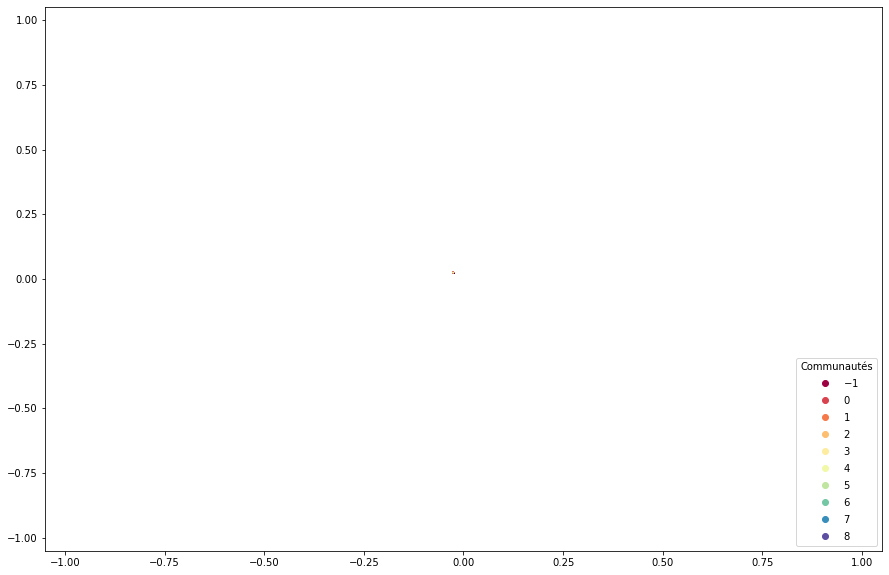

Community  0  consists of  6761  users, i.e.  0.26589845439886733 % of the total number of users.
Community  1  consists of  6031  users, i.e.  0.23718881503913164 % of the total number of users.
Community  2  consists of  5114  users, i.e.  0.20112478861053212 % of the total number of users.
Community  3  consists of  2062  users, i.e.  0.08109489912297951 % of the total number of users.
Community  4  consists of  1444  users, i.e.  0.05679002634994297 % of the total number of users.
Community  5  consists of  829  users, i.e.  0.03260313839619303 % of the total number of users.
Community  6  consists of  545  users, i.e.  0.021433908837062966 % of the total number of users.
Community  7  consists of  458  users, i.e.  0.018012349077751996 % of the total number of users.
Community  8  consists of  387  users, i.e.  0.015220041687969482 % of the total number of users.
Community -1 (other users) consists of  1796  users, i.e.  0.07063357847956896 % of the total number of users.
Etape  1

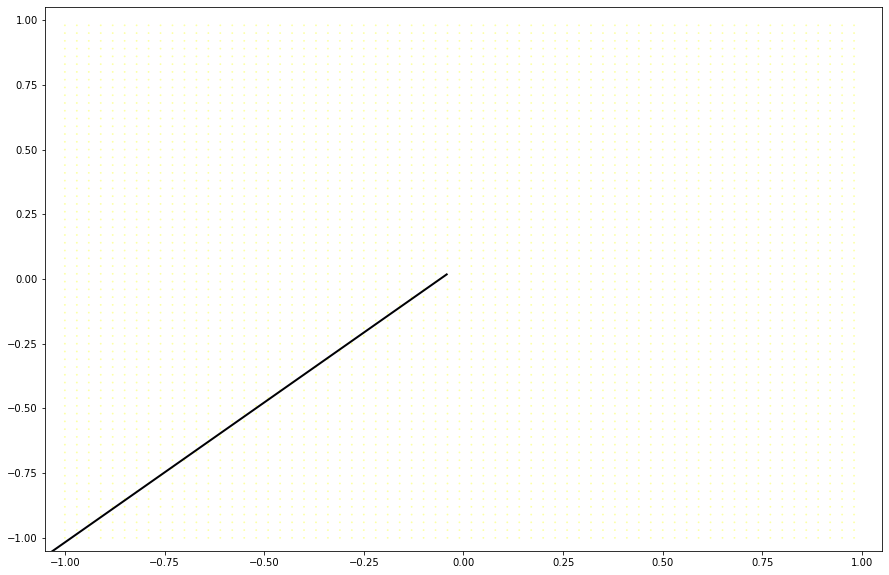

Embeddings at time  tensor(43252.)


100%|██████████| 25427/25427 [00:00<00:00, 1102994.81it/s]


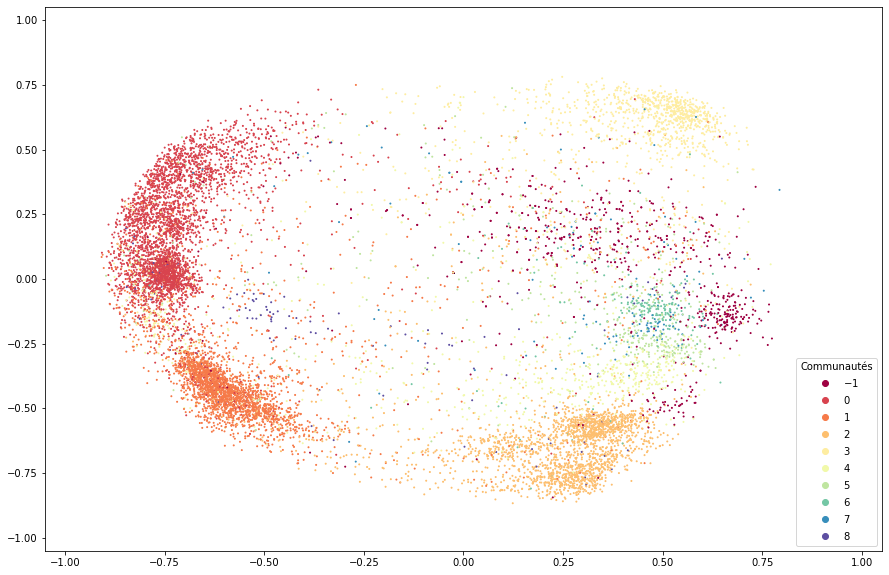

Etape  2  sur  3
Evolutions between embeddings at time  tensor(86781.)  and at time  tensor(43252.) .


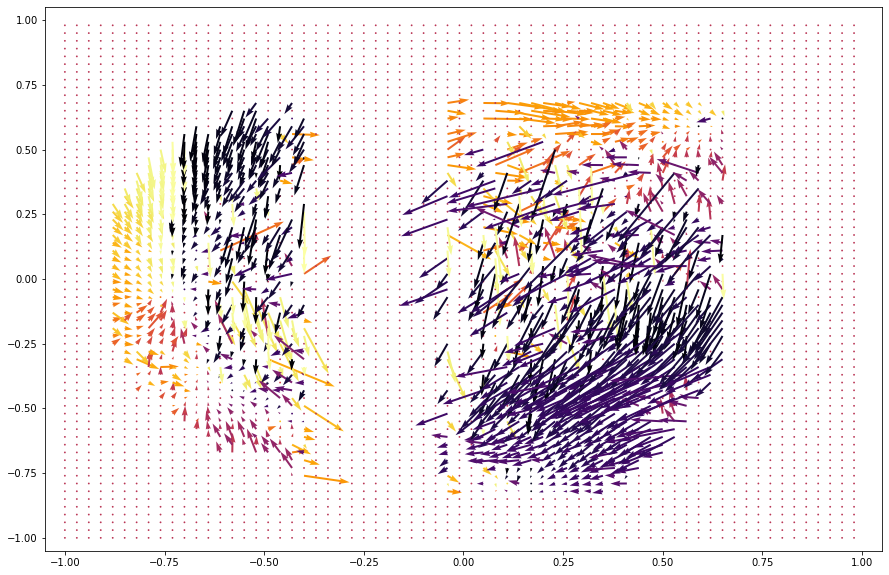

Embeddings at time  tensor(86781.)


100%|██████████| 25427/25427 [00:00<00:00, 884206.51it/s]


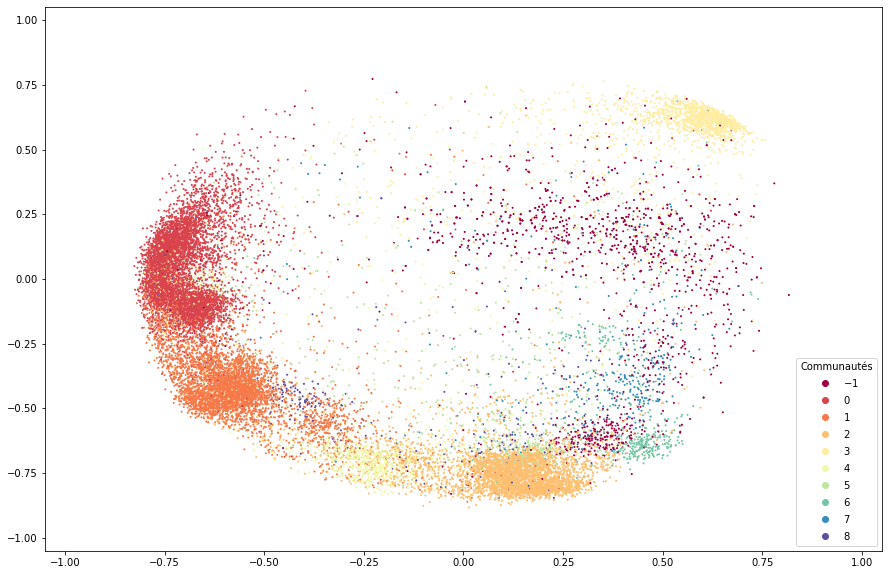

Etape  3  sur  3
Evolutions between embeddings at time  tensor(129624.)  and at time  tensor(86781.) .


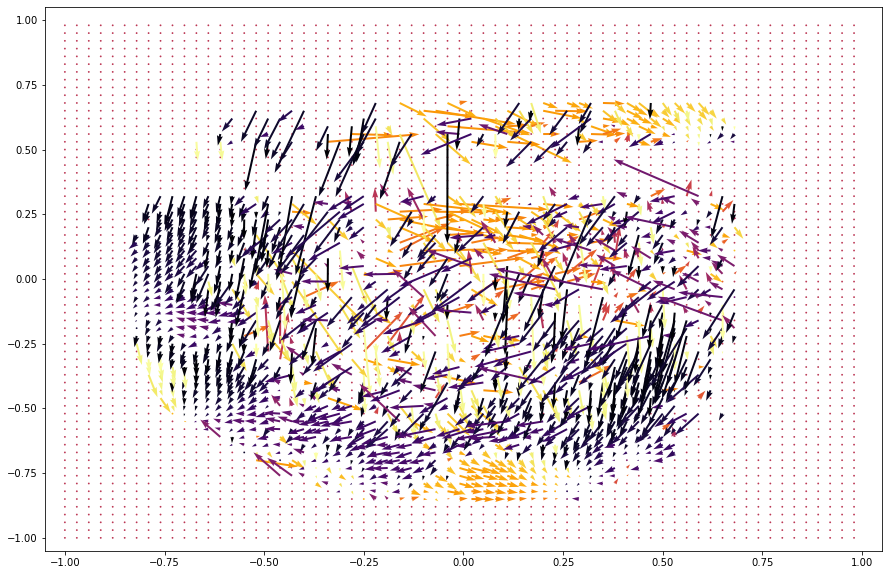

Embeddings at time  tensor(129624.)


100%|██████████| 25427/25427 [00:00<00:00, 528402.67it/s]


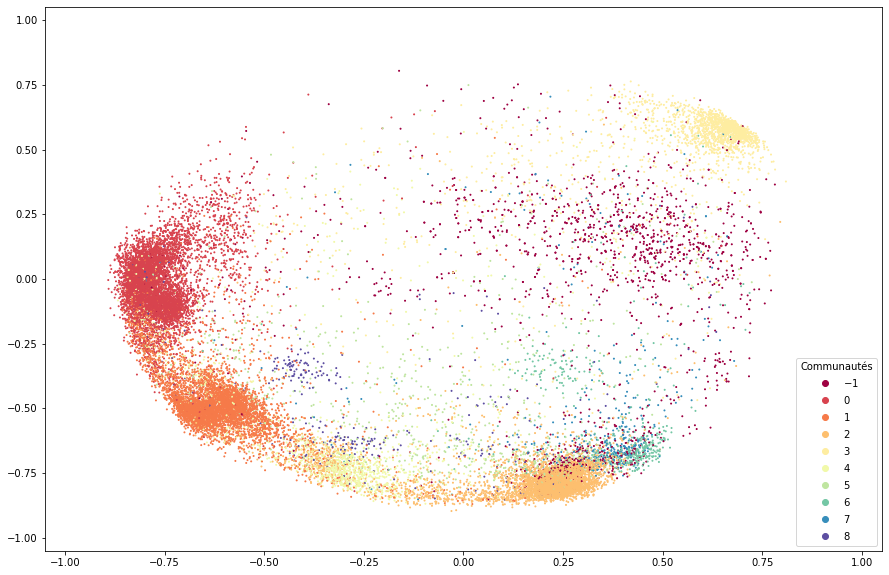

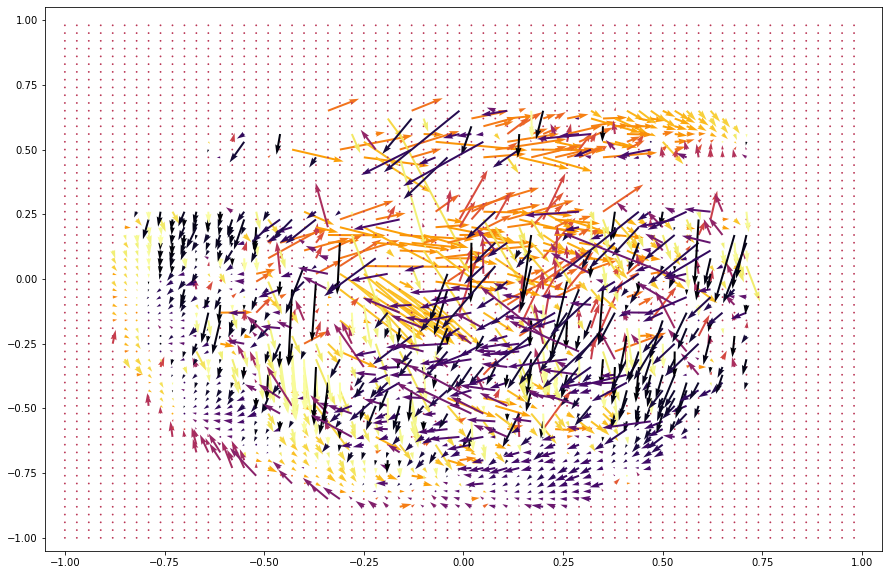

Final embeddings


100%|██████████| 25427/25427 [00:00<00:00, 813862.70it/s]


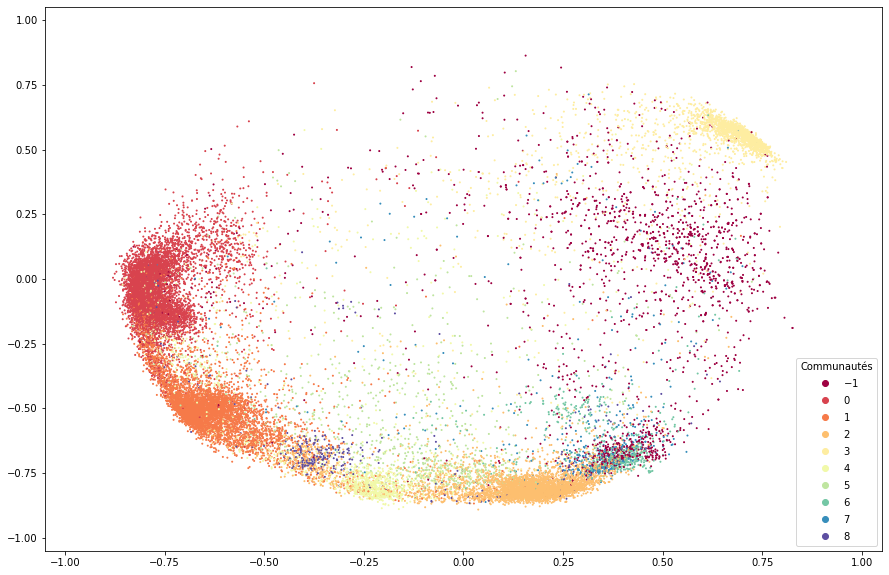

Community  0  consists of  6761  users, i.e.  0.26589845439886733 % of the total number of users.
Community  1  consists of  6031  users, i.e.  0.23718881503913164 % of the total number of users.
Community  2  consists of  5114  users, i.e.  0.20112478861053212 % of the total number of users.
Community  3  consists of  2062  users, i.e.  0.08109489912297951 % of the total number of users.
Community  4  consists of  1444  users, i.e.  0.05679002634994297 % of the total number of users.
Community  5  consists of  829  users, i.e.  0.03260313839619303 % of the total number of users.
Community  6  consists of  545  users, i.e.  0.021433908837062966 % of the total number of users.
Community  7  consists of  458  users, i.e.  0.018012349077751996 % of the total number of users.
Community  8  consists of  387  users, i.e.  0.015220041687969482 % of the total number of users.
Community -1 (other users) consists of  1796  users, i.e.  0.07063357847956896 % of the total number of users.


In [10]:
model.memory.__init_memory__()
arrows_list = eval_dynamic(model, method_PCA_emb.components_, full_data, NUM_NEIGHBORS, time_step = 43200, batch_size = batch_size,
            values = [-1,1,-1,1], step_arrow = 0.03, threshold_tile = 10, clip_value = 10, plt_emb = True, nb_com = 9)

## C. Analysis of vector fields

Vectors' norms distributions:

Plot  1 / 4


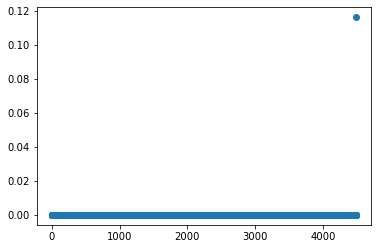

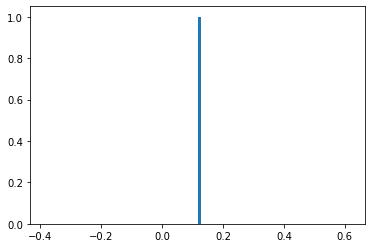

Plot  2 / 4


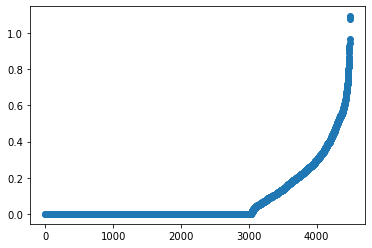

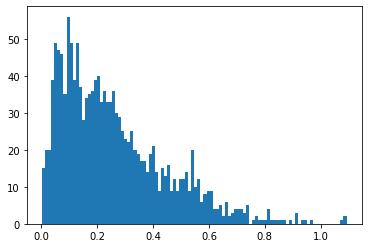

Plot  3 / 4


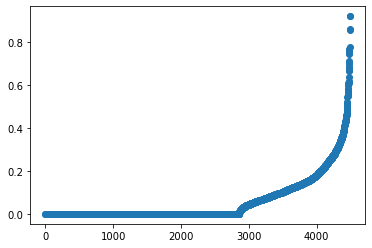

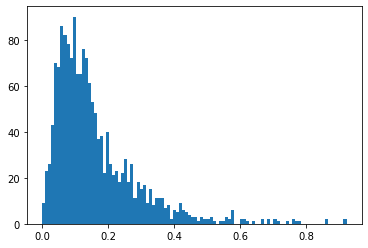

Plot  4 / 4


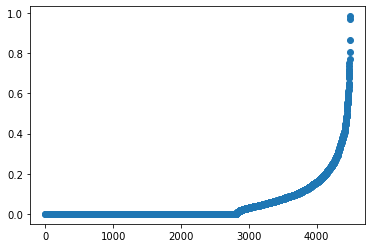

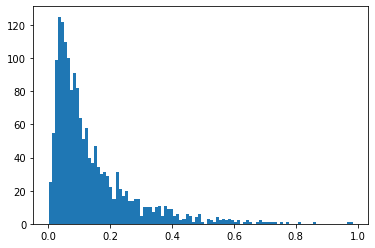

Global distribution


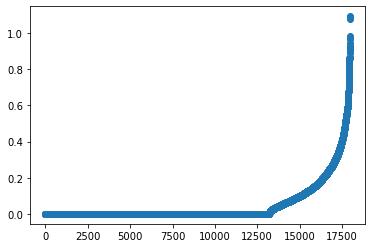

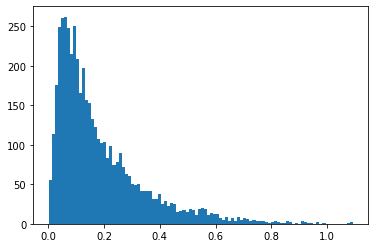

In [11]:
# Distributions plot by plot

for img in range(len(arrows_list)):
    norms = np.linalg.norm(arrows_list[img][1], axis = 1)
    print('Plot ', img+1, '/', len(arrows_list))
    plt.scatter(np.arange(arrows_list[img][1].shape[0]), np.sort(norms))
    plt.show()
    plt.hist(norms[np.where(norms!=0)[0]], bins = 100)
    plt.show()
    
# Global distribution

diff_tot = np.array([])
for img in range(len(arrows_list)):
    diff_tot = np.hstack((diff_tot,np.linalg.norm(arrows_list[img][1], axis = 1)))

print('Global distribution')
plt.scatter(np.arange(len(diff_tot)), np.sort(diff_tot))
plt.show()
plt.hist(diff_tot[np.where(diff_tot!=0)[0]], bins = 100)
plt.show()

Vectors' angles distributions:

Plot  1 / 4


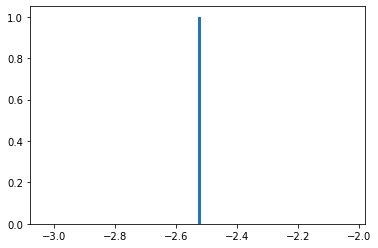

Plot  2 / 4


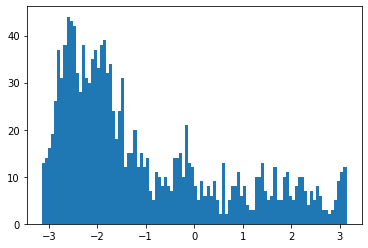

Plot  3 / 4


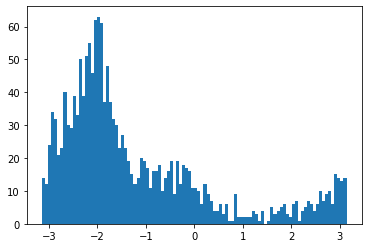

Plot  4 / 4


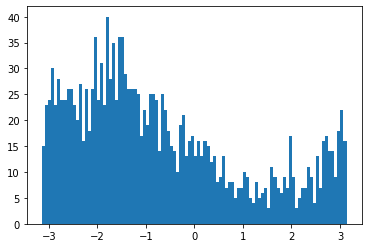

Global distribution


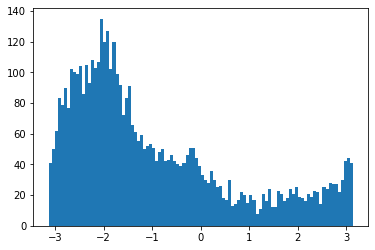

In [12]:
# Distributions plot by plot

for img in range(len(arrows_list)):
    angles = np.angle(arrows_list[img][1].T[0]+1j*arrows_list[img][1].T[1])
    print('Plot ', img+1, '/', len(arrows_list))
    plt.hist(angles[np.where(angles!=0)[0]], bins = 100)
    plt.show()
    
# Global distribution

diff_tot = np.array([])
for img in range(len(arrows_list)):
    diff_tot = np.hstack((diff_tot,np.angle(arrows_list[img][1].T[0]+1j*arrows_list[img][1].T[1])))

print('Global distribution')
plt.hist(diff_tot[np.where(diff_tot!=0)[0]], bins = 100)
plt.show()